In [13]:
#%load_ext autoreload
#%autoreload 2
import os
import numpy as np
import scipy.ndimage
import cv2 as cv
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.io import loadmat
from PIL import Image



In [14]:
#1 Square and resize image to 1024x1024 (2^10)
#2 Get mosaic (tiles of size 128x128, 8x8 in a grid. 64 total)
#3 Classify each tile
#4 Overlay classification result on original image

In [15]:
#img_pth = "C:/Users/mikae/git/mfanalysis/examples/example_data/1D1F3679-00A9-42E8-BAD3-DBDAE3CC1991.jpg"
img_pth = "examples/example_data/_90_cartilage_loss-B1D40D5C-5096-46C9-A76E-A15572474D53.jpg"

img = Image.open(img_pth).convert("L")
x, y = img.size

cropy = y if y < x else x
cropx = y if y < x else x

startx = x // 2 - (cropx // 2)
starty = y // 2 - (cropy // 2)

#img = img[starty:starty + cropy, startx:startx + cropx]
img = img.crop((startx, starty, startx+cropx, starty+cropy))
img = img.resize((1024,1024))
#img = scipy.misc.imresize(img, (1024, 1024))
img = np.array(img)

circles = cv.HoughCircles(img, cv.HOUGH_GRADIENT, 3, int(img.shape[0]*2), minRadius=int(img.shape[0]*0.3))[0][0]


In [16]:
#img_pth = "C:/Users/mikae/git/mfanalysis/examples/example_data/1D1F3679-00A9-42E8-BAD3-DBDAE3CC1991.jpg"
img_pth = "examples/example_data/_90_cartilage_loss-B1D40D5C-5096-46C9-A76E-A15572474D53.jpg"

img = np.array(Image.open(img_pth).convert("L"))
circles = cv.HoughCircles(img, cv.HOUGH_GRADIENT, 3, int(img.shape[0]*2), minRadius=int(img.shape[0]*0.3))[0][0]

if circles[2]*2 < min(img.shape):    
    
    starty = int(circles[0] - circles[2])
    endy = int(circles[0] + circles[2])
    startx = int(circles[1] - circles[2])
    endx = int(circles[1] + circles[2])
    
    img = img[startx:endx, starty:endy]

else:
    x, y = img.shape

    cropy = y if y < x else x
    cropx = y if y < x else x

    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)

    
    
img = Image.fromarray(img).resize((1024, 1024))
img = np.array(img)



[934.5 514.5 427.5]


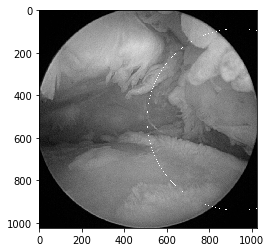

In [17]:
print(circles)

img_cpy = img.copy()
cv.circle(img_cpy, (circles[0], circles[1]), circles[2], (255))
plt.imshow(img_cpy, cmap=plt.get_cmap('gray'))

In [11]:
if circles[2]*2 < min(img.shape):    
    
    startx = int(circles[0] - circles[2])
    endx = int(circles[0] + circles[2])
    starty = int(circles[1] - circles[2])
    endy = int(circles[1] + circles[2])
    
    img = img[startx:endx, starty:endy]
        

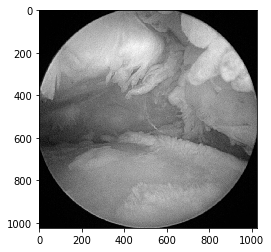

In [18]:
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [19]:
tile_side = 128
n_tiles = int(min(img.shape)/tile_side)


In [20]:

mosaic = []
for i in range(n_tiles):
    mosaic.append([img[i*tile_side:(i+1)*tile_side, j*tile_side:(j+1)*tile_side] for j in range(n_tiles)])
    

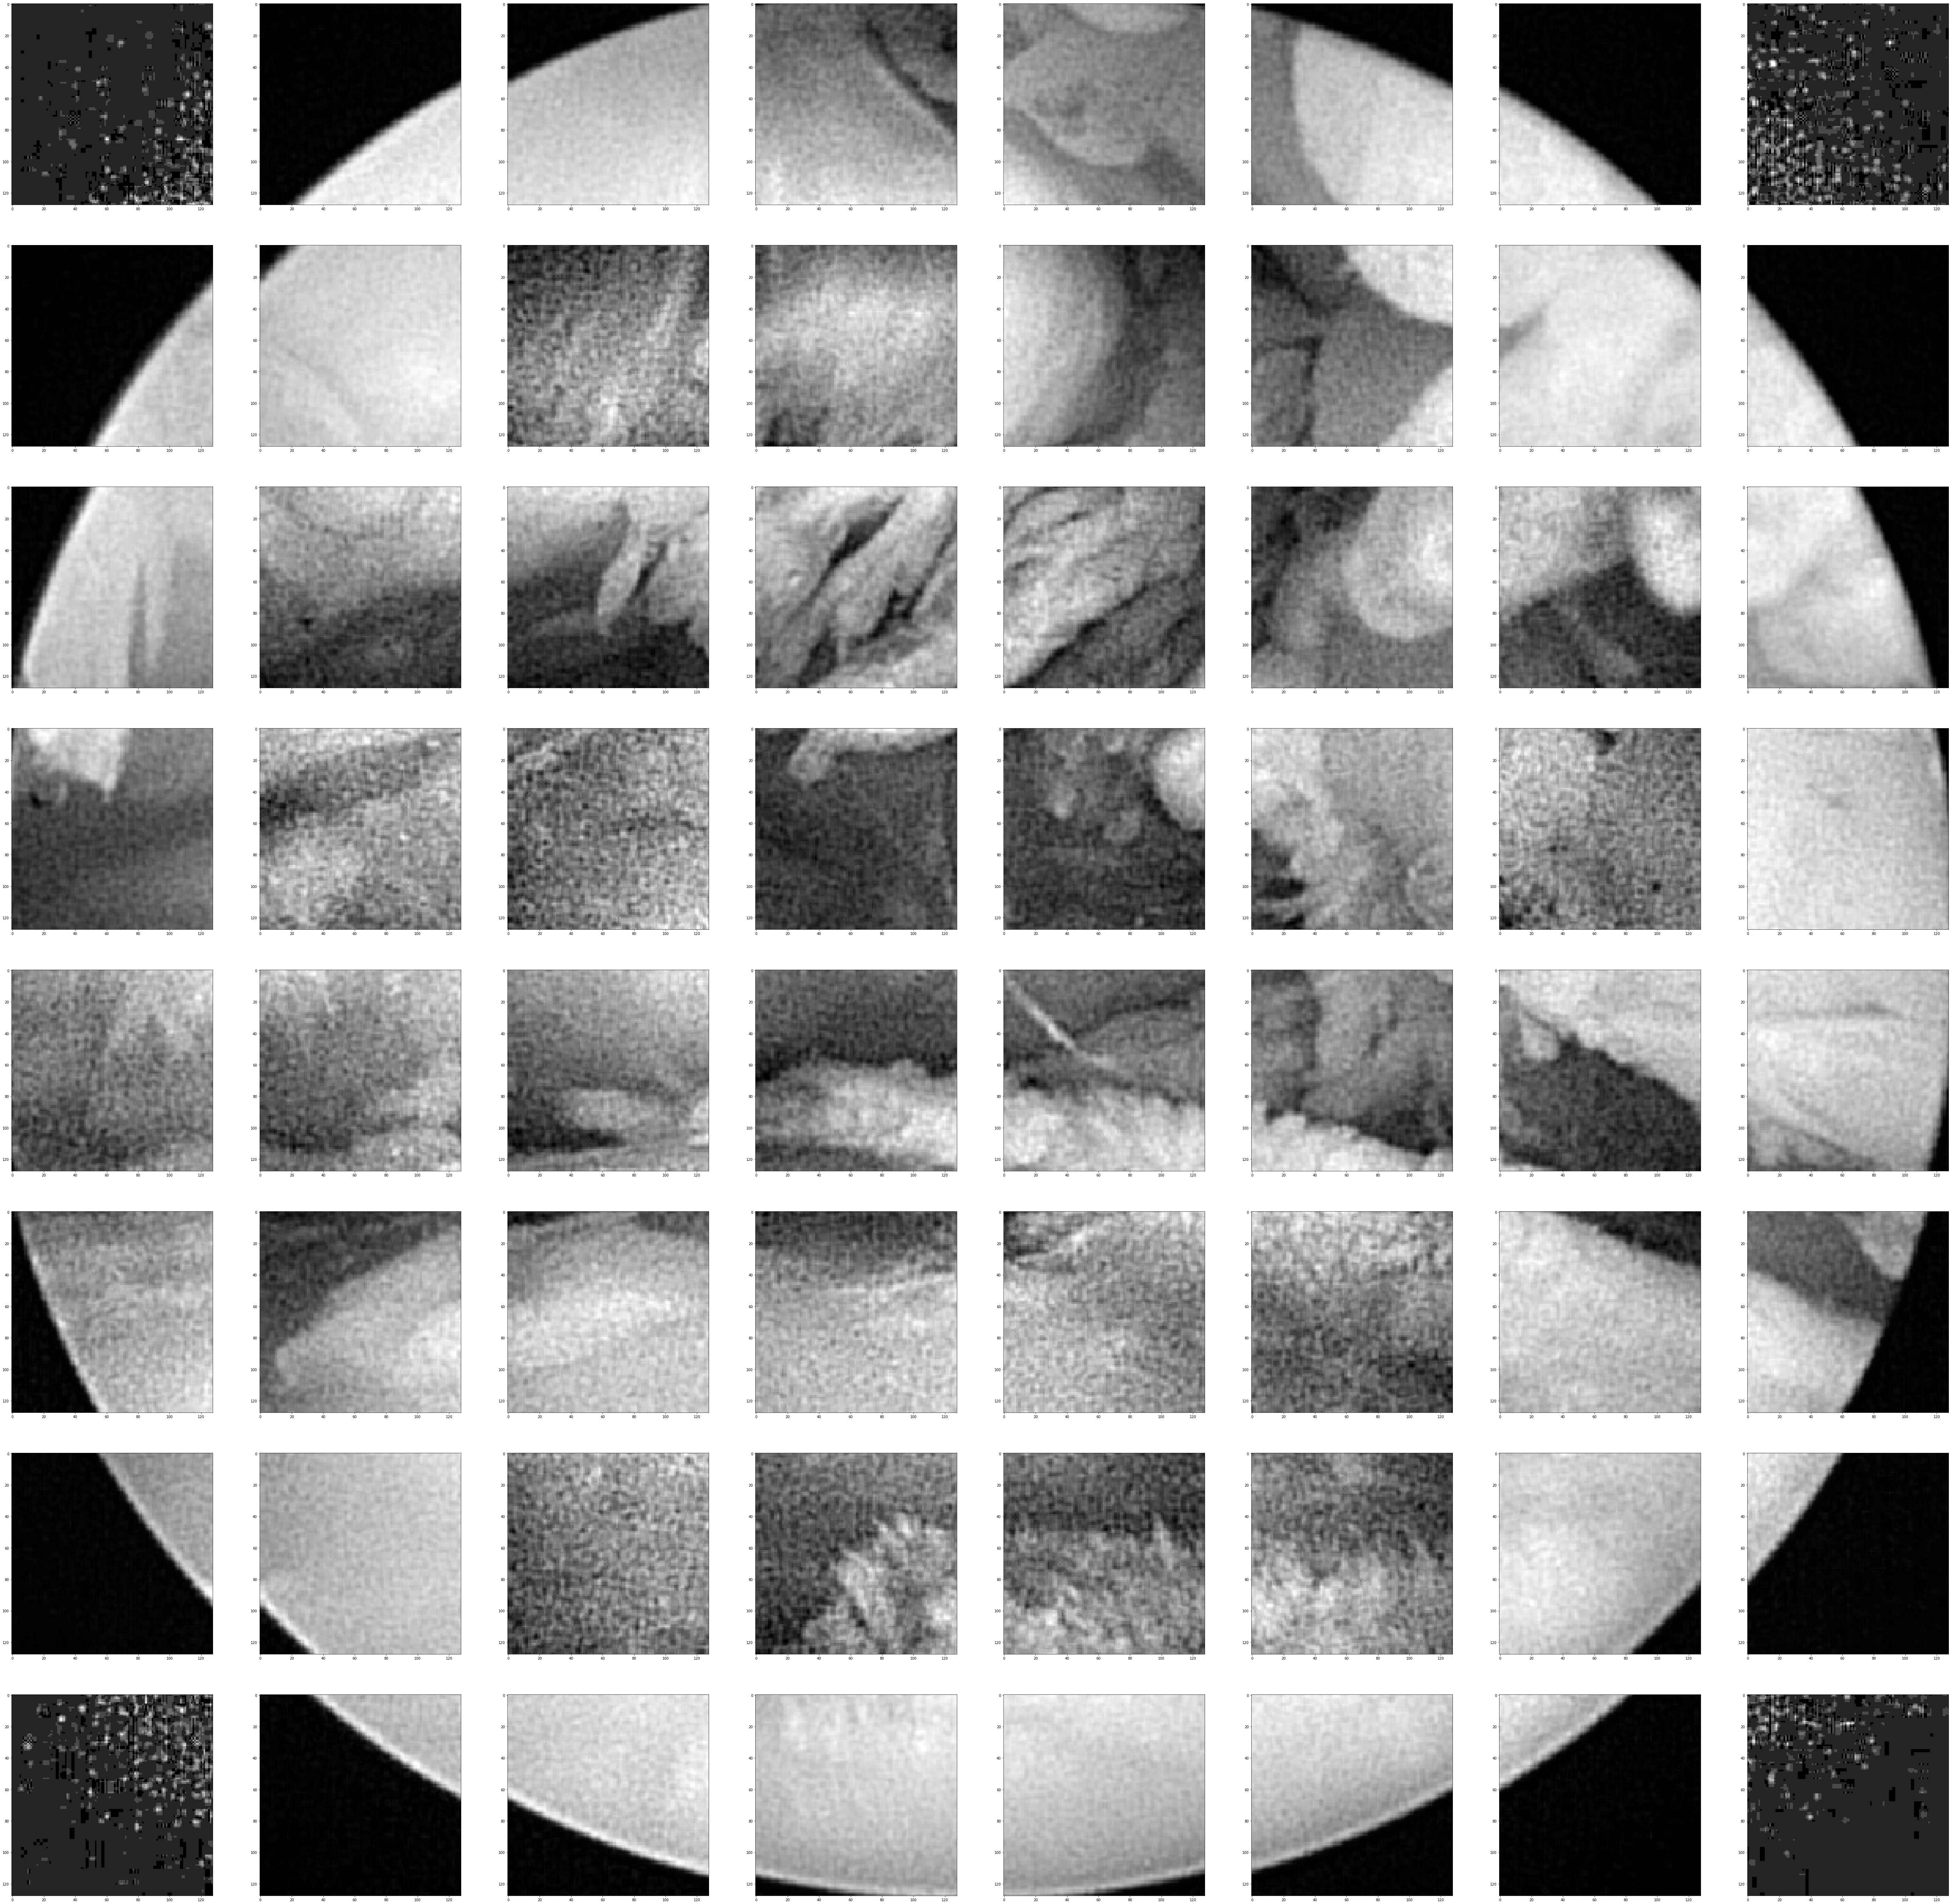

In [21]:
plt.rcParams['figure.figsize'] = [100, 100]
f, axarr = plt.subplots(n_tiles, n_tiles)
for i in range(n_tiles):
    for j in range(n_tiles):
        axarr[i, j].imshow(mosaic[i][j], cmap=plt.get_cmap('gray'))


In [24]:
import mfanalysis as mf
mfa = mf.MFA()
mfa.wt_name = 'db3'
mfa.p = 2
mfa.j1 = 1
mfa.j2 = 2
mfa.q = np.arange(-4, 5)
mfa.n_cumul = 3
mfa.wtype = 0
mfa.verbose = 0

In [23]:

import time
n=10

start = time.time()
for _ in range(n):
    features = []
    mfa.analyze_no_estimation(img)
    for i in range(n_tiles):
        features.append([])
        for j in range(n_tiles):
            tile_idx = (i*tile_side, (i+1)*tile_side, j*tile_side, (j+1)*tile_side)
            
            if np.mean(img[i*tile_side:(i+1)*tile_side, j*tile_side:(j+1)*tile_side]) > 40:
                #mfa.perform_estimations_subset(tile_idx, 1, 2)    
                mfa.analyze_no_estimation(mosaic[i][j])            
                mfa.perform_estimations()
                feature = mfa.construct_feature_matrix()
            else:
                feature = [0]*30

            
            #mfa.analyze_no_estimation(mosaic[i][j])            
            #mfa.perform_estimations()
            
            #features[i].append(mfa.construct_feature_matrix())
            features[i].append(feature)
            
            #print(features[i][j][1])
end = time.time() - start
print("TID:", end/n*1000)




TID: 1532.0486783981323


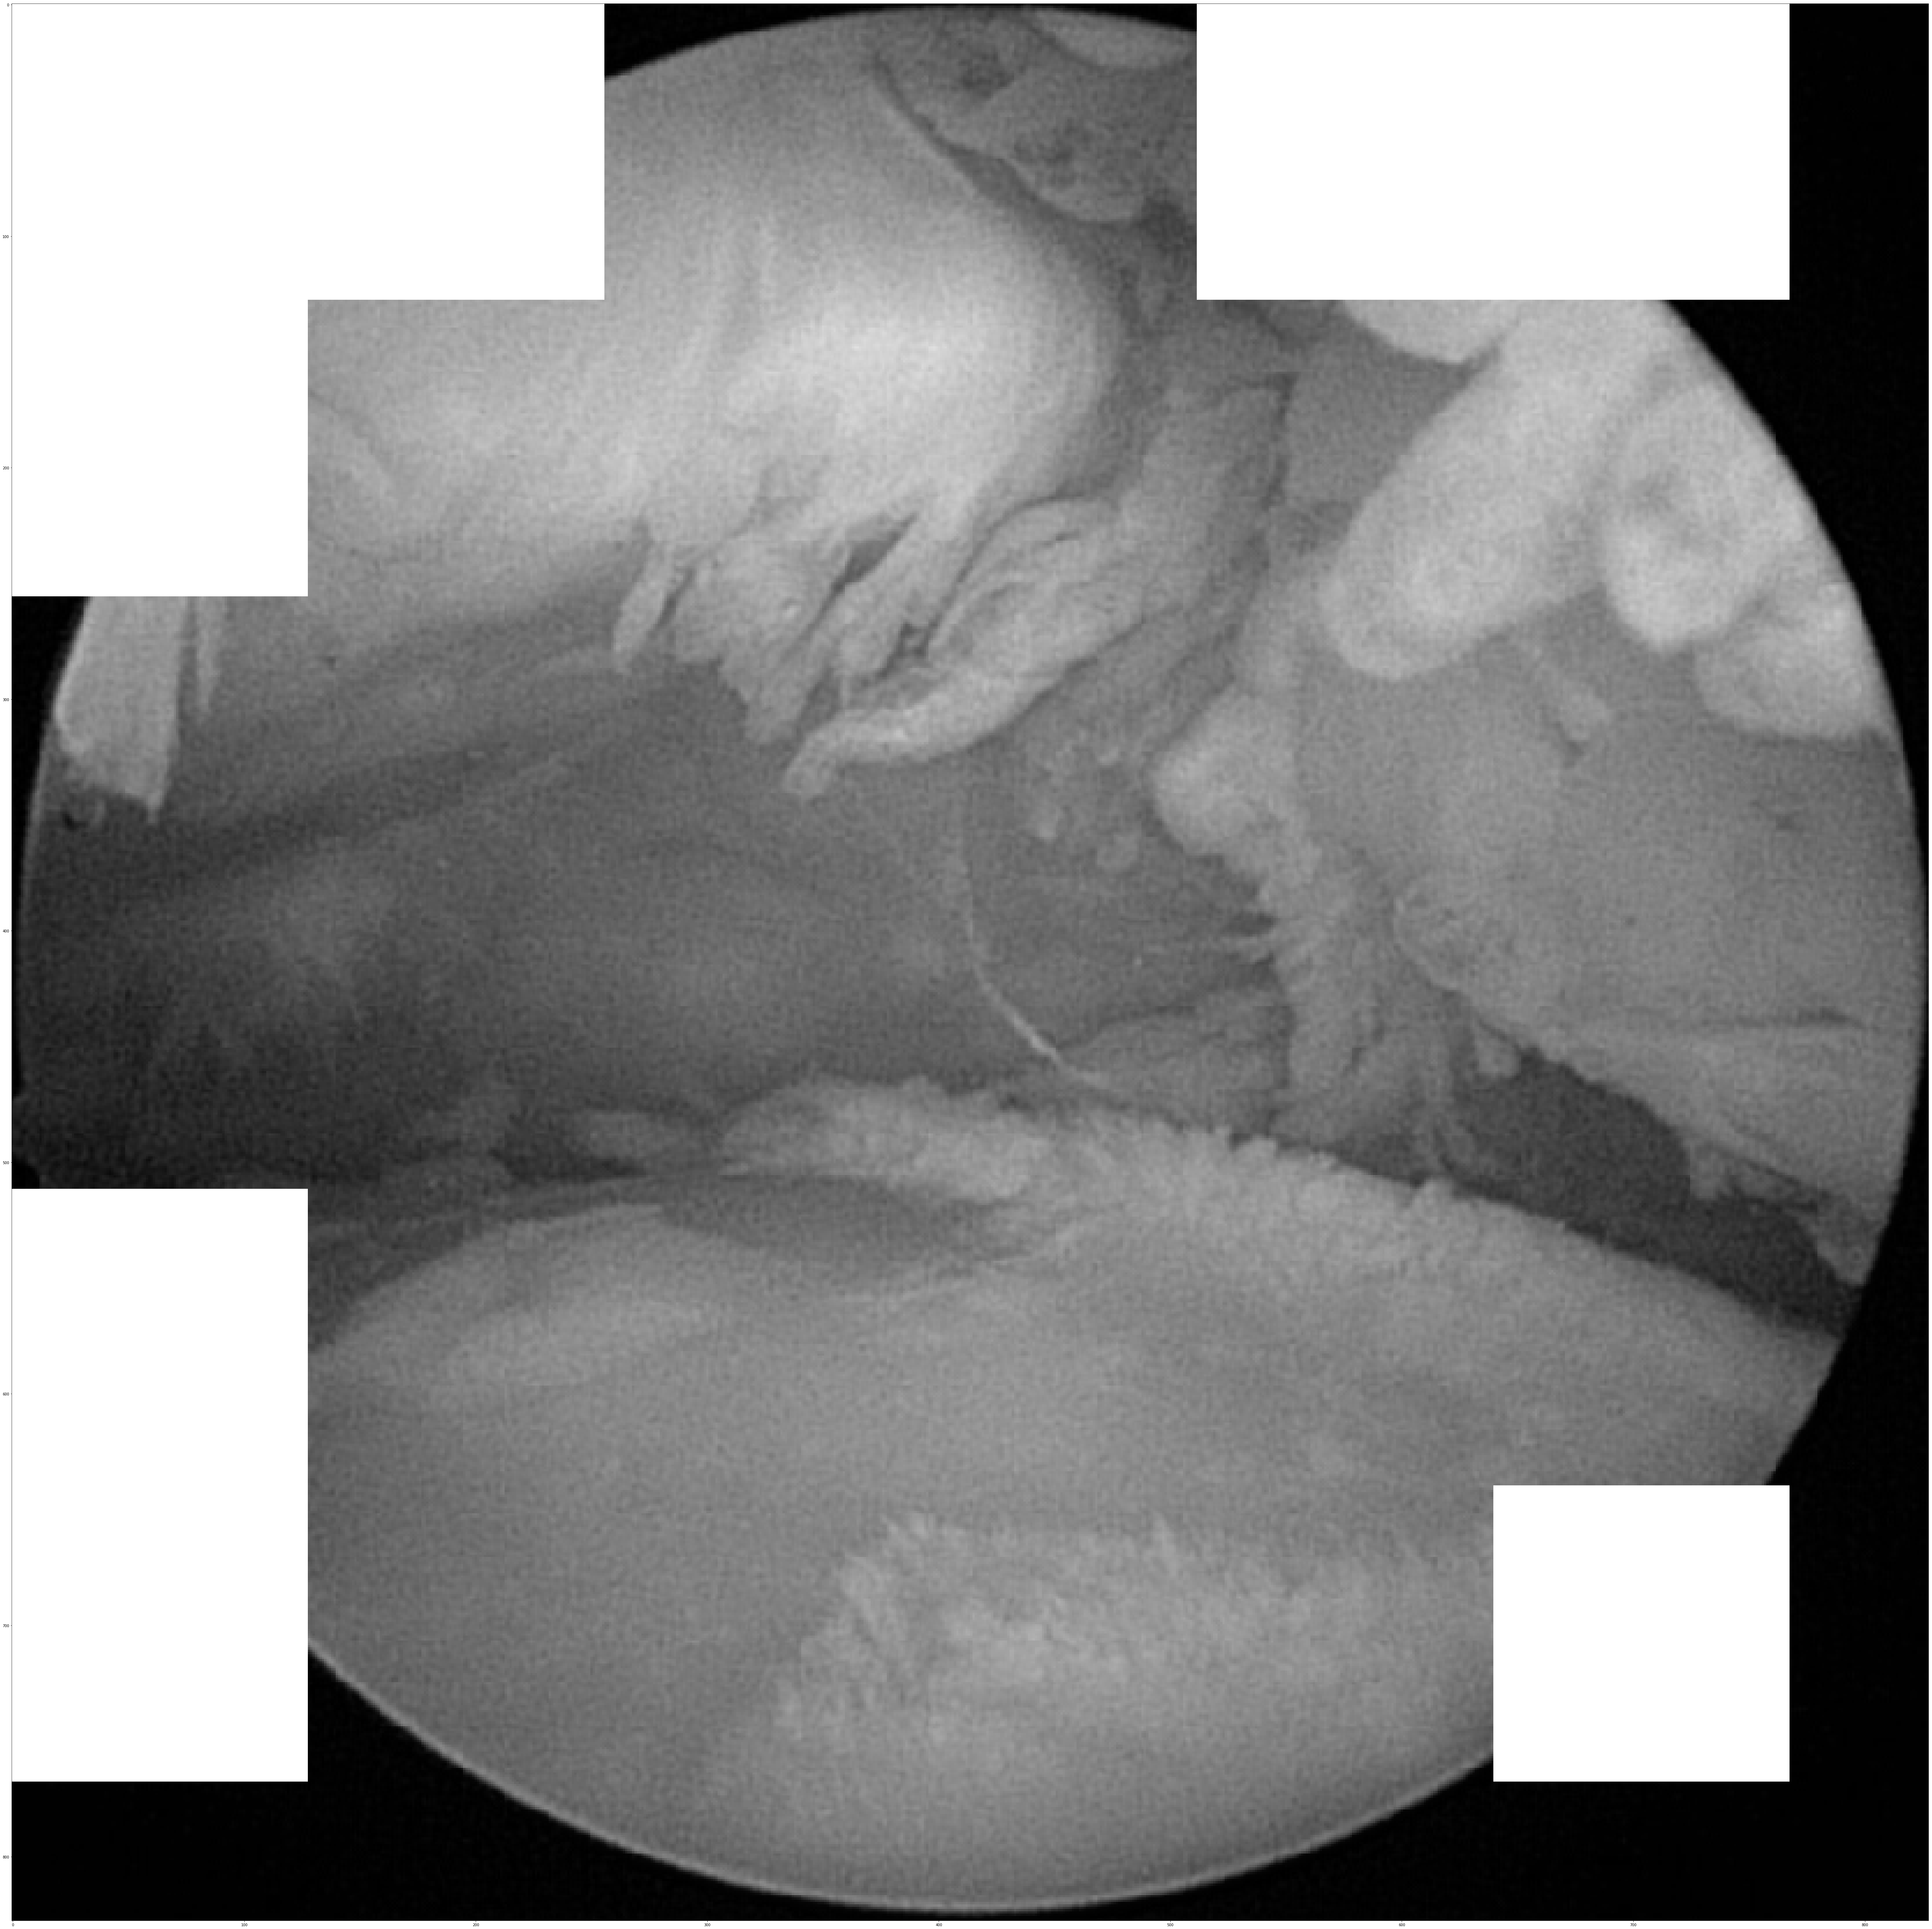

In [81]:
#print(mfa.cumulants.log_cumulants)
#Any c2 that is not negative indicates a bogus D(h) i.e. not concave spectrum
img_cpy = img.copy()
for i in range(n_tiles):
    for j in range(n_tiles):
        if features[i][j][1] >= 0 :
            img_cpy[i*tile_side:(i+1)*tile_side, j*tile_side:(j+1)*tile_side] = 255
plt.imshow(img_cpy, cmap=plt.get_cmap('gray'))

In [11]:
print(features)

[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], array([ 1.09272739,  0.22960512,  0.32804355,  1.79611204,  1.92932959,
        2.01599675,  2.03565237,  2.        ,  2.21179103,  2.4556573 ,
        1.51309813,  0.39227222,  1.06984205,  1.03180314,  0.99740361,
        0.98698066,  1.09272739,  1.47376047,  1.67304927,  1.30432724,
        0.97919834, -4.07548024, -3.02473901, -2.01080398, -1.02263303,
        0.        ,  1.26196943,  2.89044124,  4.39988358,  5.52452115]), array([ 8.17329400e-01, -2.95629874e-02, -2.73919809e-04,  1.75499281e+00,
        1.86522288e+00,  1.94083084e+00,  1.98526464e+00,  2.00000000e+00,
        1.98508802e+00,  1.93957229e+00,  1.86195024e+00,  1.75090443e+00,
        9.38088257e-01,  9.06632271e-01,  8.76419005e-01,  8.46815410e-01,
        8.17329400e-01,  7.87576954e-01,  7.57270015e-01,  7.26246024e-01,
        6.94532892e-01, -3.50734584e+00, -2.58511969e+00, -1.69366885e+00,
       -8.32080049e-01